In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

file_url = 'https://raw.githubusercontent.com/YufanPeter/EPL_Analysis/refs/heads/main/EPL_fyp.csv'

df = pd.read_csv(file_url)

In [2]:
# Checks whether each match record in the dataset has a complementary record
# with reversed home/away teams (same season, same teams but swapped venue).
def has_complementary_record(row, df):
    if row['Venue'] == 'Away':
        match = df[
            (df['Season'] == row['Season']) &
            (df['Team'] == row['Opponent']) &
            (df['Opponent'] == row['Team']) &
            (df['Venue'] == 'Home')
        ]
    elif row['Venue'] == 'Home':
        match = df[
            (df['Season'] == row['Season']) &
            (df['Team'] == row['Opponent']) &
            (df['Opponent'] == row['Team']) &
            (df['Venue'] == 'Away')
        ]
    else:
        return False

    return not match.empty

df['has_match'] = df.apply(lambda row: has_complementary_record(row, df), axis=1)

if df['has_match'].all():
    print("All matched!")
else:
    missing_matches = df[~df['has_match']]
    print("Lack of data")
    print(missing_matches)

All matched!


In [3]:
df_home = df[(df['Venue'] == 'Home') & (df['has_match'])].copy()
df_away = df[(df['Venue'] == 'Away') & (df['has_match'])].copy()

matched_pairs = []
used_away = set()

for home_index, home_row in df_home.iterrows():
    away = df_away[
        (df_away['Season'] == home_row['Season']) &
        (df_away['Team'] == home_row['Opponent']) &
        (df_away['Opponent'] == home_row['Team']) &
        (~df_away.index.isin(used_away))
    ]

    if not away.empty:
        away_index = away.index[0]
        matched_pairs.append((home_index, away_index))
        used_away.add(away_index)

count = 0
for home_idx, away_idx in matched_pairs:
    home_referee = df.loc[home_idx, 'Referee']
    away_referee = df.loc[away_idx, 'Referee']
    if home_referee == away_referee:
        count += 1

print("Number of matched pairs with the same referee:", count)

Number of matched pairs with the same referee: 3800


In [4]:
# ew features:
# 'is_win': binary indicator of match result (1 if win, 0 otherwise).
# 'Team_Reputation': classify each team as 'High' if in the Big-Six, 'Low' otherwise.
big_six = ["Arsenal", "Chelsea", "Liverpool", "Manchester City", "Manchester United", "Tottenham Hotspur"]

df['is_win'] = (df['Result'] == 'W').astype(int)
df['Team_Reputation'] = df['Team'].apply(lambda x: "High" if x in big_six else "Low")

print(df['Team_Reputation'].value_counts())

Team_Reputation
Low     5320
High    2280
Name: count, dtype: int64


In [5]:
# Extract match records where one team is Big-Six and the other is not.
# Record whether the Big-Six team (high reputation) won the match (High_Win = 1 or 0).
win_df = df.copy()

win_stats = []

for (idx1, idx2) in matched_pairs:
  rec1 = win_df.loc[idx1]
  rec2 = win_df.loc[idx2]

  rep1 = "High" if rec1['Team'] in big_six else "Low"
  rep2 = "High" if rec2['Team'] in big_six else "Low"

  if rep1 != rep2:
    if rep1 == "High":
      high_record = rec1
      low_record = rec2
    else:
      high_record = rec2
      low_record = rec1

    win_stats.append({
        'Referee': high_record['Referee'],
        'High_Team': high_record['Team'],
        'Low_Team': low_record['Team'],
        'High_Win': high_record['is_win']
        })

win_stats_df = pd.DataFrame(win_stats)
print(win_stats_df.head())

          Referee        High_Team                Low_Team  High_Win
0    Robert Jones  Manchester City        Newcastle United         1
1  Michael Oliver  Manchester City                  Fulham         1
2  Anthony Taylor  Manchester City       Nottingham Forest         1
3    Robert Jones  Manchester City  Brighton & Hove Albion         1
4    Craig Pawson  Manchester City             Bournemouth         1


In [6]:
# For each referee, calculate: Difference in win rates (diff_win_rate)
# Only include referees with at least 5 such matches for statistical reliability.
grouped = win_stats_df.groupby('Referee').agg(
    matches=('High_Win', 'count'),
    high_wins=('High_Win', 'sum')
).reset_index()

grouped['high_win_rate'] = (grouped['high_wins'] / grouped['matches']).round(2)
grouped['low_win_rate'] = 1 - grouped['high_win_rate']
grouped['diff_win_rate'] = grouped['high_win_rate'] - grouped['low_win_rate']
grouped = grouped[(grouped['matches'] >= 5)]

print(grouped.head())

          Referee  matches  high_wins  high_win_rate  low_win_rate  \
0  Andre Marriner      112         72           0.64          0.36   
1     Andy Madley       34         20           0.59          0.41   
2  Anthony Taylor      124         82           0.66          0.34   
3       Chris Foy       11         10           0.91          0.09   
4  Chris Kavanagh       67         50           0.75          0.25   

   diff_win_rate  
0           0.28  
1           0.18  
2           0.32  
3           0.82  
4           0.50  


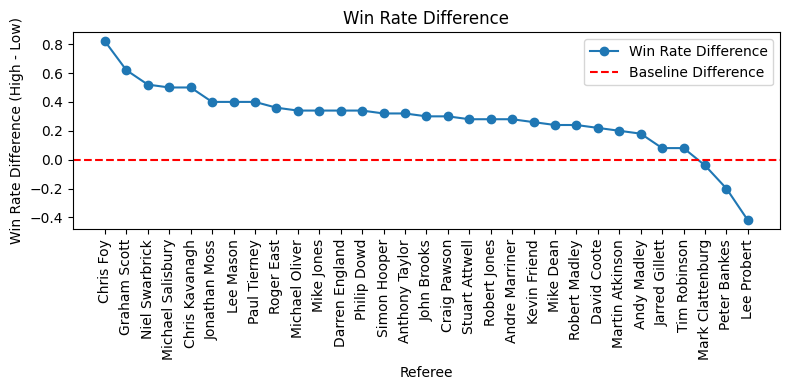

In [7]:
# Visualizes the difference in win rates (diff_win_rate) for each referee
# when officiating matches between Big-Six and non-Big-Six teams.
# A line plot is used to show the trend of bias, with a red dashed line indicating the neutral baseline.
ref_stats_sorted = grouped.sort_values(by='diff_win_rate', ascending=False)

# plt.figure(figsize=(10, 10))
# sns.barplot(x='diff_win_rate', y='Referee', data=ref_stats_sorted, palette='coolwarm', legend=False)
# plt.title("Difference in Win Rate")
# plt.xlabel("Win Rate Difference")
# plt.ylabel("Referee")
# plt.show()

plt.figure(figsize=(8,4))
plt.plot(ref_stats_sorted['Referee'], ref_stats_sorted['diff_win_rate'], marker='o', linestyle='-', label='Win Rate Difference')

plt.axhline(0, color='red', linestyle='--', label='Baseline Difference')
plt.xlabel('Referee')
plt.ylabel('Win Rate Difference (High - Low)')
plt.title('Win Rate Difference')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

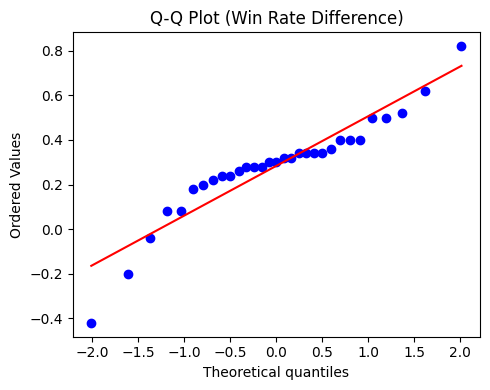

Shapiro-Wilk test: statistic = 0.910, p-value = 0.013


In [8]:
# Checks the normality of the 'diff_win_rate' distribution using a Q-Q plot and the Shapiro-Wilk test.
# The result helps determine whether a parametric test is appropriate.
import scipy.stats as stats

grouped_stats = grouped['diff_win_rate'].dropna()
plt.figure(figsize=(5,4))

stats.probplot(grouped_stats, dist="norm", plot=plt)
plt.title("Q-Q Plot (Win Rate Difference)")
plt.tight_layout()
plt.show()

stat, p_value = shapiro(grouped['diff_win_rate'].dropna())
print("Shapiro-Wilk test: statistic = {:.3f}, p-value = {:.3f}".format(stat, p_value))

In [9]:
from scipy.stats import shapiro

stat, p = shapiro(grouped_stats)

print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p}")

Shapiro-Wilk Test Statistic: 0.9097266963128684
P-value: 0.012718310481746247


In [10]:
# Perform Wilcoxon signed-rank test to assess whether the median of 'diff_win_rate' significantly differs from zero.
from scipy.stats import wilcoxon

stat, p_value = wilcoxon(grouped['diff_win_rate'])
print(f"Wilcoxon signed-rank test: t-statistic = {stat:.3f}, p-value = {p_value:.3f}")

Wilcoxon signed-rank test: t-statistic = 32.500, p-value = 0.000


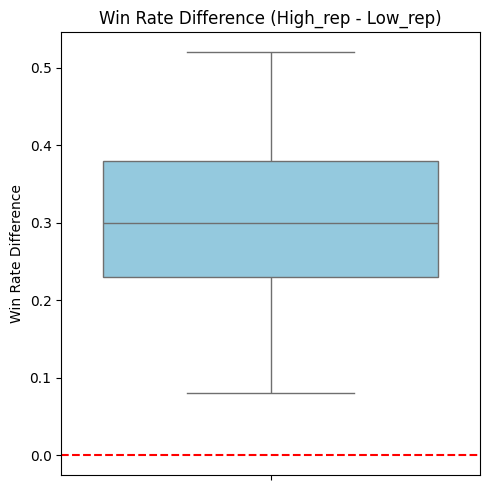

In [11]:
plt.figure(figsize=(5,5))
sns.boxplot(y=grouped['diff_win_rate'], color='skyblue', showfliers=False)
plt.axhline(0, color='red', linestyle='--')
plt.title("Win Rate Difference (High_rep - Low_rep)")
plt.ylabel("Win Rate Difference")
plt.tight_layout()
plt.show()

In [45]:
# For each matched pair of matches, determine which team is a Big-Six club (High reputation).
# Calculate and compare disciplinary actions (cards, fouls) and their ratios between High and Low reputation teams.
cards_df = df.copy()
cards_stats = []

for (idx1, idx2) in matched_pairs:
    rec1 = cards_df.loc[idx1]
    rec2 = cards_df.loc[idx2]

    rep1 = "High" if rec1['Team'] in big_six else "Low"
    rep2 = "High" if rec2['Team'] in big_six else "Low"

    if rep1 != rep2:
        high_record = rec1 if rep1 == "High" else rec2
        low_record = rec2 if rep1 == "High" else rec1

        try:
            high_cards = high_record['CrdY'] + high_record['2CrdY'] + high_record['CrdR']
            low_cards  = low_record['CrdY']  + low_record['2CrdY']  + low_record['CrdR']

            high_fls = high_record['Fls (fouls committed)']
            low_fls  = low_record['Fls (fouls committed)']

            high_ratio = round(high_fls / high_cards, 2) if high_cards != 0 else np.nan
            low_ratio  = round(low_fls / low_cards, 2) if low_cards != 0 else np.nan

            diff_cards = high_cards - low_cards
            diff_fls   = high_fls - low_fls
            diff_ratio = high_ratio - low_ratio if not np.isnan(high_ratio) and not np.isnan(low_ratio) else np.nan

            cards_stats.append({
                'Referee': high_record['Referee'],
                'High_Cards': high_cards,
                'Low_Cards': low_cards,
                'High_Fls': high_fls,
                'Low_Fls': low_fls,
                'High_Ratio': high_ratio,
                'Low_Ratio': low_ratio,
                'Diff_Cards': diff_cards,
                'Diff_Fls': diff_fls,
                'Diff_Ratio': diff_ratio
            })

        except Exception as e:
            print(f"Error processing match {idx1}-{idx2}: {e}")
            continue

cards_stats_df = pd.DataFrame(cards_stats)
print(cards_stats_df.head())

          Referee  High_Cards  Low_Cards  High_Fls  Low_Fls  High_Ratio  \
0    Robert Jones           1          5        13       11       13.00   
1  Michael Oliver           2          4        12       12        6.00   
2  Anthony Taylor           4          7         5       17        1.25   
3    Robert Jones           6          2         9       11        1.50   
4    Craig Pawson           0          1         8        9         NaN   

   Low_Ratio  Diff_Cards  Diff_Fls  Diff_Ratio  
0       2.20          -4         2       10.80  
1       3.00          -2         0        3.00  
2       2.43          -3       -12       -1.18  
3       5.50           4        -2       -4.00  
4       9.00          -1        -1         NaN  


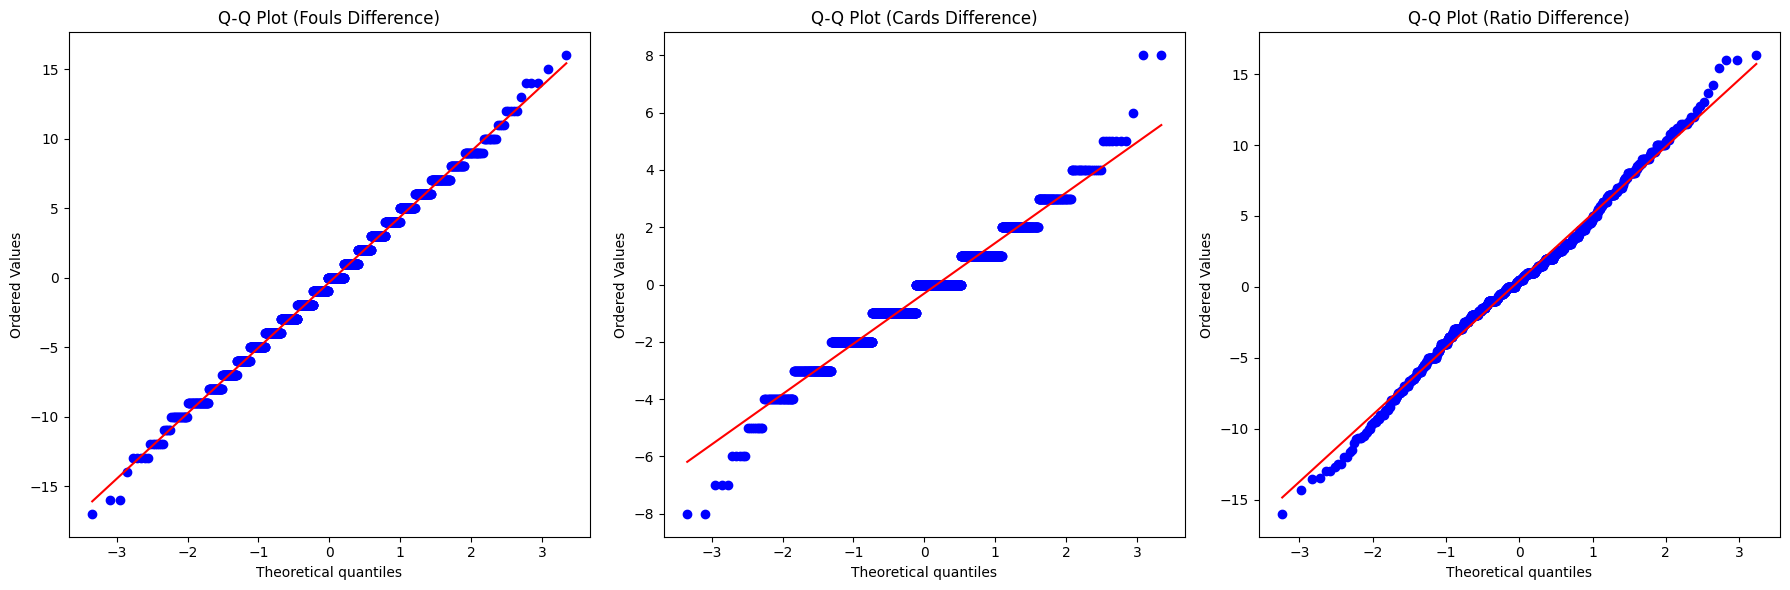

In [46]:
# Determine normal distribution
fls = cards_stats_df['Diff_Fls'].dropna()
crds = cards_stats_df['Diff_Cards'].dropna()
ratio = cards_stats_df['Diff_Ratio'].dropna()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

stats.probplot(fls, dist="norm", plot=axs[0])
axs[0].set_title("Q-Q Plot (Fouls Difference)")

stats.probplot(crds, dist="norm", plot=axs[1])
axs[1].set_title("Q-Q Plot (Cards Difference)")

stats.probplot(ratio, dist="norm", plot=axs[2])
axs[2].set_title("Q-Q Plot (Ratio Difference)")

plt.tight_layout()
plt.show()

In [47]:
shapiro_fls = shapiro(fls)
shapiro_crds = shapiro(crds)
shapiro_ratio = shapiro(ratio)

print("Shapiro-Wilk Test (Fouls Difference):", shapiro_fls.pvalue)
print("Shapiro-Wilk Test (Cards Difference):", shapiro_crds.pvalue)
print("Shapiro-Wilk Test (Ratio Difference):", shapiro_ratio.pvalue)

Shapiro-Wilk Test (Fouls Difference): 5.968060479219065e-05
Shapiro-Wilk Test (Cards Difference): 7.758544489818721e-20
Shapiro-Wilk Test (Ratio Difference): 1.615599889871238e-05


In [48]:
from scipy.stats import ttest_1samp

t_stat_cards, p_val_cards = ttest_1samp(cards_stats_df['Diff_Cards'].dropna(), 0)
t_stat_fouls, p_val_fouls = ttest_1samp(cards_stats_df['Diff_Fls'].dropna(), 0)
t_stat_ratio, p_val_ratio = ttest_1samp(cards_stats_df['Diff_Ratio'].dropna(), 0)

print(f"t-test for Diff_Cards: t-statistic = {t_stat_cards:.3f}, p-value = {p_val_cards:.3f}")
print(f"t-test for Diff_Fouls: t-statistic = {t_stat_fouls:.3f}, p-value = {p_val_fouls:.3f}")
print(f"t-test for Diff_Ratio: t-statistic = {t_stat_ratio:.3f}, p-value = {p_val_ratio:.3f}")

t-test for Diff_Cards: t-statistic = -7.127, p-value = 0.000
t-test for Diff_Fouls: t-statistic = -2.969, p-value = 0.003
t-test for Diff_Ratio: t-statistic = 3.086, p-value = 0.002


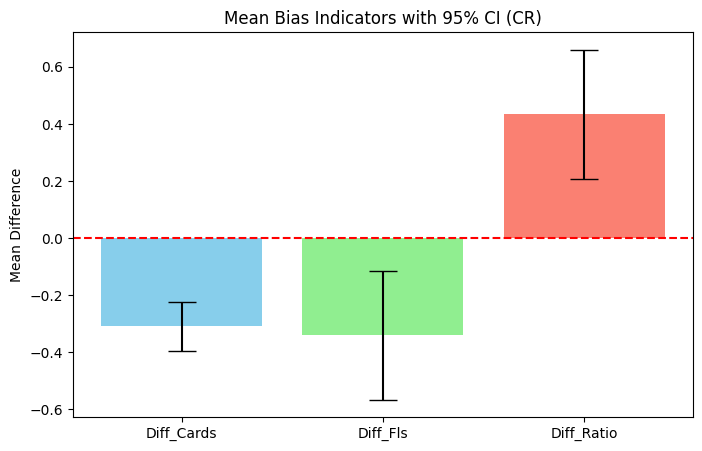

In [50]:
# Compute mean and 95% confidence interval for each bias indicator (cards, fouls, foul/card ratio)
# Plot mean differences with error bars to visualize referee bias under Club Reputation factor (CR)
features = ['Diff_Cards', 'Diff_Fls', 'Diff_Ratio']
means = [cards_stats_df[feat].mean() for feat in features]
stds = [cards_stats_df[feat].std() for feat in features]
n = len(cards_stats_df)

cis = [1.96 * std / np.sqrt(n) for std in stds]

plt.figure(figsize=(8, 5))
plt.bar(features, means, yerr=cis, capsize=10, color=['skyblue', 'lightgreen', 'salmon'])
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('Mean Difference')
plt.title('Mean Bias Indicators with 95% CI (CR)')
plt.show()

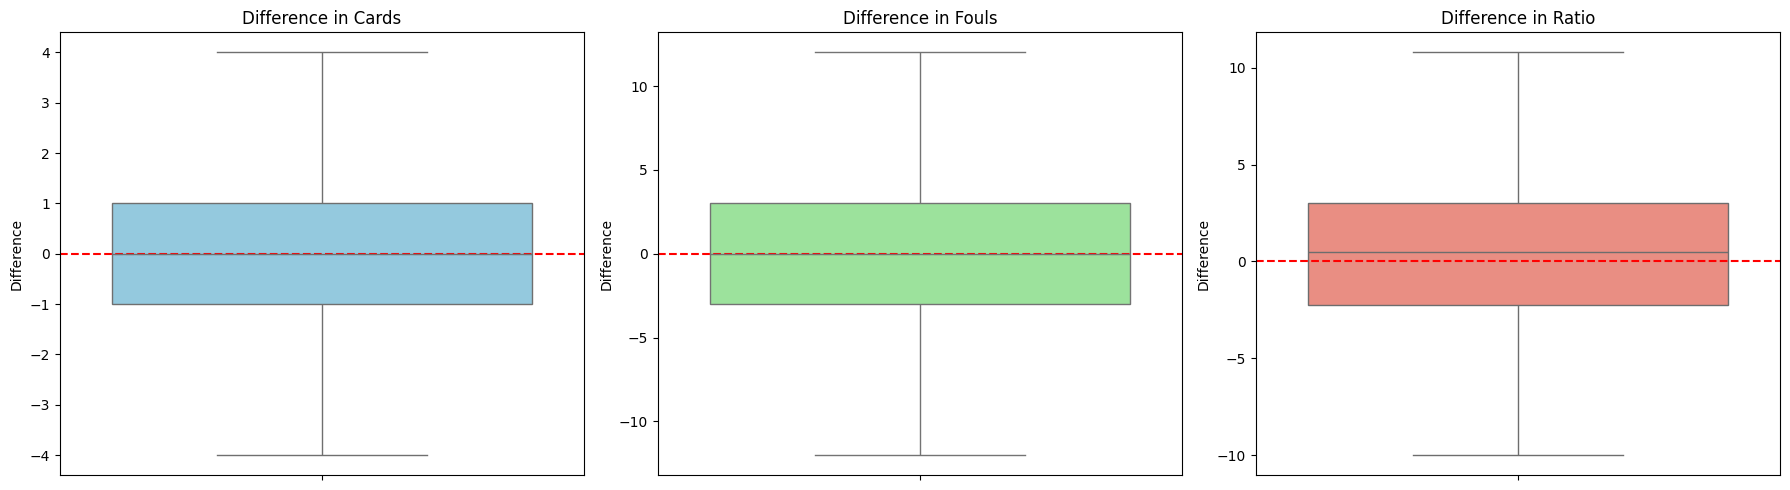

In [51]:
features = ['Diff_Cards', 'Diff_Fls', 'Diff_Ratio']
titles = ['Difference in Cards', 'Difference in Fouls', 'Difference in Ratio']
colors = ['skyblue', 'lightgreen', 'salmon']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(features):
    sns.boxplot(
        y=cards_stats_df[feature],
        ax=axes[i],
        color=colors[i],
        showfliers=False
    )
    axes[i].axhline(0, color='red', linestyle='--')
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('Difference')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

In [53]:
# Aggregate club reputation-related statistics per referee, focusing on:
# Average differences in cards, fouls, and foul/card ratio between Big-Six and non-Big-Six clubs
# Only include referees who have officiated more than 5 such matches
# Sort referees by average difference in foul/card ratio
referee_agg_club_rep = cards_stats_df.groupby('Referee').agg(
    total_matches=('Referee', 'count'),
    avg_high_cards=('High_Cards', 'mean'),
    avg_low_cards=('Low_Cards', 'mean'),
    avg_diff_cards=('Diff_Cards', 'mean'),
    std_diff_cards=('Diff_Cards', 'std'),

    avg_high_fls=('High_Fls', 'mean'),
    avg_low_fls=('Low_Fls', 'mean'),
    avg_diff_fls=('Diff_Fls', 'mean'),
    std_diff_fls=('Diff_Fls', 'std'),

    avg_high_ratio=('High_Ratio', 'mean'),
    avg_low_ratio=('Low_Ratio', 'mean'),
    avg_diff_ratio=('Diff_Ratio', 'mean'),
    std_diff_ratio=('Diff_Ratio', 'std')
).reset_index().round(2)

referee_diff_club_rep = referee_agg_club_rep[['Referee', 'total_matches', 'avg_diff_cards', 'avg_diff_fls', 'avg_diff_ratio']]
referee_diff_club_rep = referee_diff_club_rep[referee_diff_club_rep['total_matches'] > 5]

referee_diff_club_rep = referee_diff_club_rep.sort_values(by='avg_diff_ratio', ascending=False)

print(referee_diff_club_rep.reset_index(drop=True))

              Referee  total_matches  avg_diff_cards  avg_diff_fls  \
0           Chris Foy             11           -0.82          2.27   
1         Lee Probert              7           -1.29         -1.43   
2      Darren England             18           -0.33          0.50   
3          Mike Jones             36           -0.56         -0.22   
4         Philip Dowd              6            0.33          5.00   
5        Simon Hooper             32           -0.66         -1.00   
6         Andy Madley             34           -0.82         -0.74   
7      Michael Oliver            110           -0.25         -0.24   
8        Peter Bankes             25           -0.48         -0.92   
9        Robert Jones             25           -0.08          0.96   
10       Paul Tierney             83           -0.40         -0.28   
11    Martin Atkinson             86           -0.17          0.93   
12      Robert Madley             40           -0.60         -0.82   
13     Niel Swarbric

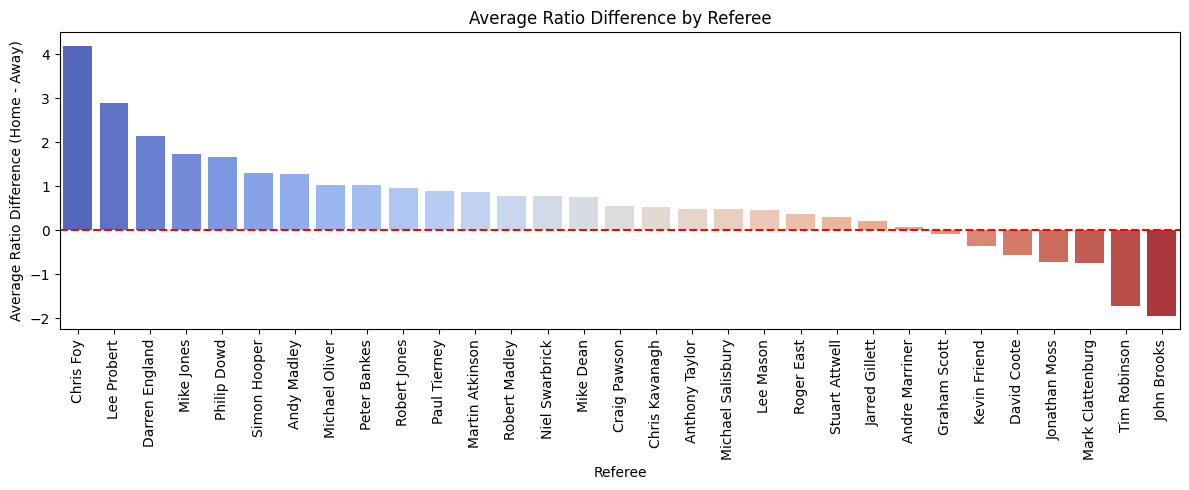

In [56]:
# Plot average foul-to-card ratio difference (Big-Six - non-Big-Six) for each referee.
# Higher values may indicate tolerance towards Big-Six teams.
plt.figure(figsize=(12,5))
sns.barplot(x='Referee', y='avg_diff_ratio', data=referee_diff_club_rep, palette="coolwarm")
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=90)
plt.xlabel("Referee")
plt.ylabel("Average Ratio Difference (Home - Away)")
plt.title("Average Ratio Difference by Referee")
plt.tight_layout()
plt.show()

In [57]:
# Construct a DataFrame to analyze extra time allocation and outcome changes
# in matches involving Big-Six vs non-Big-Six teams.
# It compares regular-time and final results to determine whether the outcome changed during extra time and whether the extra time might have influenced it.
extra_time_df = df.copy()

extra_time_stats = []

for (idx1, idx2) in matched_pairs:
  rec1 = win_df.loc[idx1]
  rec2 = win_df.loc[idx2]

  rep1 = "High" if rec1['Team'] in big_six else "Low"
  rep2 = "High" if rec2['Team'] in big_six else "Low"

  if rep1 != rep2:
    if rep1 == "High":
      high_record = rec1
      low_record = rec2
    else:
      high_record = rec2
      low_record = rec1

      extra_time = high_record['Second Extra Time']
      final_result = high_record['Result']

      high_extra_goal = high_record['Second Extra Team Goal']
      low_extra_goal = low_record['Second Extra Team Goal']
      diff_extra_goal = high_extra_goal - low_extra_goal

      high_regular_goal = high_record['GF (goals for)'] - high_extra_goal
      low_regular_goal = low_record['GF (goals for)'] - low_extra_goal
      diff_regular_goal = high_regular_goal - low_regular_goal

      if diff_regular_goal > 0:
        outcome = 'Leading'
      elif diff_regular_goal == 0:
        outcome = 'Drawing'
      else:
        outcome = 'Trailing'

      if outcome != 'Leading' and final_result == 'W':
        outcome_change = True
      elif outcome == 'Leading' and final_result != 'W':
        outcome_change = True
      else:
        outcome_change = False

      extra_time_stats.append({
          'Referee': high_record['Referee'],
          'Match': (high_record['Team'], low_record['Team']),
          'Regular_Time_Outcome': outcome,
          'Final_Result': final_result,
          'Outcome_Changed': outcome_change,
          'Extra_Goal_Difference': diff_extra_goal,
          'Extra_Time': extra_time,
          'Regular_Goal_Difference': diff_regular_goal
          })

extra_time_df = pd.DataFrame(extra_time_stats)
print(extra_time_df.head())

          Referee                             Match Regular_Time_Outcome  \
0     John Brooks    (Manchester City, Aston Villa)             Trailing   
1  Jarred Gillett            (Arsenal, Aston Villa)             Trailing   
2    Robert Jones  (Manchester United, Aston Villa)              Leading   
3  Chris Kavanagh  (Tottenham Hotspur, Aston Villa)              Leading   
4    Craig Pawson            (Chelsea, Aston Villa)              Drawing   

  Final_Result  Outcome_Changed  Extra_Goal_Difference  Extra_Time  \
0            L            False                      0           6   
1            L            False                      0           9   
2            W            False                      0           7   
3            W            False                      2          10   
4            D            False                      0          10   

   Regular_Goal_Difference  
0                       -1  
1                       -1  
2                        1  
3     

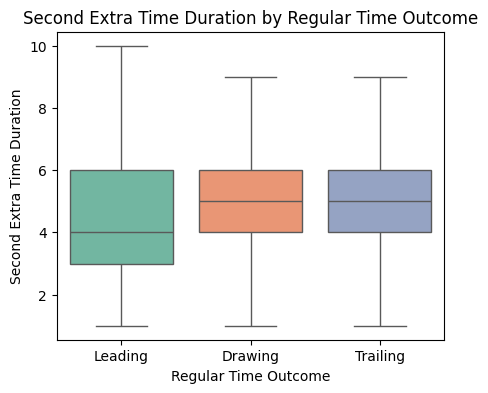

In [58]:
from scipy.stats import f_oneway, kruskal

plt.figure(figsize=(5,4))
sns.boxplot(x='Regular_Time_Outcome', y='Extra_Time', data=extra_time_df, palette="Set2", showfliers=False,
            order=["Leading", "Drawing", "Trailing"])

plt.title("Second Extra Time Duration by Regular Time Outcome")
plt.xlabel("Regular Time Outcome")
plt.ylabel("Second Extra Time Duration")
plt.show()

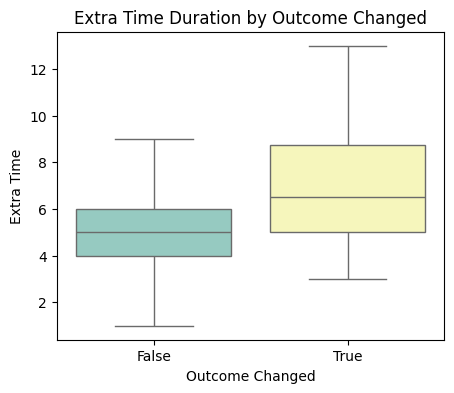

In [59]:
plt.figure(figsize=(5,4))
sns.boxplot(x='Outcome_Changed', y='Extra_Time', data=extra_time_df, palette="Set3", showfliers=False)
plt.title("Extra Time Duration by Outcome Changed")
plt.xlabel("Outcome Changed")
plt.ylabel("Extra Time")
plt.show()

In [60]:
# Apply Kruskal-Wallis H test to determine whether there is a statistically
# significant difference in extra time allocation across different match outcomes:
# 'Leading', 'Drawing', and 'Trailing'.
from scipy.stats import kruskal

group_leading = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Leading']['Extra_Time'].dropna()
group_drawing = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Drawing']['Extra_Time'].dropna()
group_trailing = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Trailing']['Extra_Time'].dropna()

stat_kruskal, p_kruskal = kruskal(group_leading, group_drawing, group_trailing)

print(f"Kruskal-Wallis test: stat = {stat_kruskal:.3f}, p = {p_kruskal:.3f}")

Kruskal-Wallis test: stat = 12.506, p = 0.002


In [61]:
!pip install scikit_posthocs

In [62]:
# Apply Dunn's post-hoc test with Holm correction to identify
# which pairs among 'Leading', 'Drawing', and 'Trailing' differ significantly
from scikit_posthocs import posthoc_dunn

p_dunn = (posthoc_dunn([group_leading, group_drawing, group_trailing], p_adjust="holm")).round(2)

print("Dunn's test p-values:")
print(p_dunn)

Dunn's test p-values:
      1     2     3
1  1.00  0.02  0.01
2  0.02  1.00  0.72
3  0.01  0.72  1.00


Optimization terminated successfully.
         Current function value: 0.108282
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:     is_Outcome_Changed   No. Observations:                  840
Model:                          Logit   Df Residuals:                      834
Method:                           MLE   Df Model:                            5
Date:                Thu, 08 May 2025   Pseudo R-squ.:                  0.4545
Time:                        16:27:34   Log-Likelihood:                -90.957
converged:                       True   LL-Null:                       -166.75
Covariance Type:            nonrobust   LLR p-value:                 6.119e-31
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -5.2883      0.655

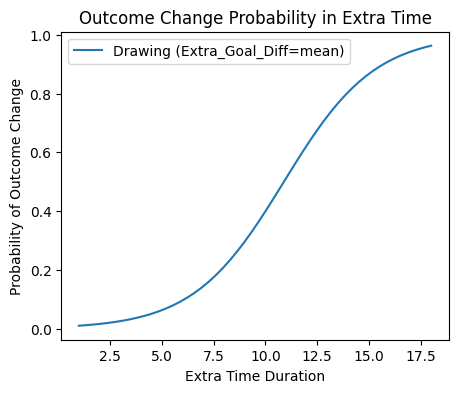

In [63]:
# Fit a logistic regression model to assess whether extra time duration affects outcome change.
# The model includes extra time, extra time goal difference, match state (leading/drawing/trailing), and their interaction as predictors.
import statsmodels.formula.api as smf

extra_time_df['is_Outcome_Changed'] = extra_time_df['Outcome_Changed'].astype(int)

model_outcome = smf.logit("is_Outcome_Changed ~ Extra_Time + Extra_Goal_Difference + C(Regular_Time_Outcome) + Extra_Time:Extra_Goal_Difference", data=extra_time_df).fit()
print(model_outcome.summary())

time_range = np.linspace(extra_time_df['Extra_Time'].min(), extra_time_df['Extra_Time'].max(), 50)
df_pred = pd.DataFrame({
    'Extra_Time': time_range,
    'Extra_Goal_Difference': extra_time_df['Extra_Goal_Difference'].mean(),
    'Regular_Time_Outcome': 'Drawing'
})
df_pred['pred_prob'] = model_outcome.predict(df_pred)

plt.figure(figsize=(5,4))
plt.plot(df_pred['Extra_Time'], df_pred['pred_prob'], label="Drawing (Extra_Goal_Diff=mean)")
plt.xlabel("Extra Time Duration")
plt.ylabel("Probability of Outcome Change")
plt.title("Outcome Change Probability in Extra Time")
plt.legend()
plt.show()

In [64]:
# Create a copy of the main DataFrame and filter out matches with missing expected goals (xG) values.
xg_df = df.copy()

xg_df = xg_df.dropna(subset=['xG (expected goals)'])

clean_matched_pairs = []

for (home_idx, away_idx) in matched_pairs:
    if home_idx in xg_df.index and away_idx in xg_df.index:
        home_xg = xg_df.loc[home_idx]['xG (expected goals)']
        away_xg = xg_df.loc[away_idx]['xG (expected goals)']
        if pd.notnull(home_xg) and pd.notnull(away_xg):
            clean_matched_pairs.append((home_idx, away_idx))

print("Number of matched pairs after cleaning:", len(clean_matched_pairs))

Number of matched pairs after cleaning: 2660


In [65]:
# This block computes expected goals (xG) difference between "High reputation" (Big Six) and "Low reputation" teams
# for each matched pair. It stores the high xG, low xG, xG difference, and match outcome.
xg_stats = []

for (idx1, idx2) in matched_pairs:
  rec1 = win_df.loc[idx1]
  rec2 = win_df.loc[idx2]

  rep1 = "High" if rec1['Team'] in big_six else "Low"
  rep2 = "High" if rec2['Team'] in big_six else "Low"

  if rep1 != rep2:
    if rep1 == "High":
      high_record = rec1
      low_record = rec2
    else:
      high_record = rec2
      low_record = rec1

      high_xg = high_record['xG (expected goals)']
      low_xg = low_record['xG (expected goals)']
      diff_xg = high_xg - low_xg

      xg_stats.append({
          'Referee': high_record['Referee'],
          'high_xg': high_xg,
          'low_xg': low_xg,
          'diff_xg': diff_xg,
          'is_win': high_record['is_win']
          })

xg_stats_df = pd.DataFrame(xg_stats)
print(xg_stats_df.head())

          Referee  high_xg  low_xg  diff_xg  is_win
0     John Brooks      0.6     2.3     -1.7       0
1  Jarred Gillett      1.4     0.6      0.8       0
2    Robert Jones      1.8     2.4     -0.6       1
3  Chris Kavanagh      1.5     0.8      0.7       1
4    Craig Pawson      1.6     1.1      0.5       0


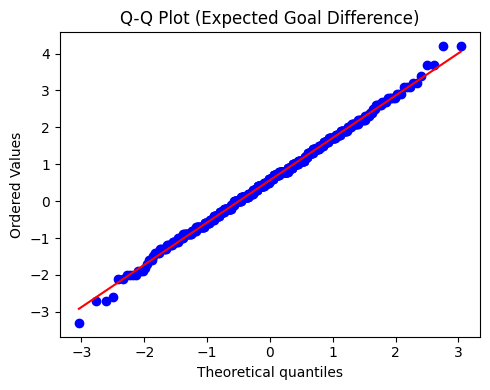

In [66]:
xg = xg_stats_df['diff_xg'].dropna()
plt.figure(figsize=(5,4))

stats.probplot(xg, dist="norm", plot=plt)
plt.title("Q-Q Plot (Expected Goal Difference)")
plt.tight_layout()
plt.show()

In [67]:
t_stat, p_val = ttest_1samp(xg_stats_df['diff_xg'].dropna(), 0)
print(f"t-test for Diff_xG: t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")

t-test for Diff_xG: t-statistic = 12.026, p-value = 0.000


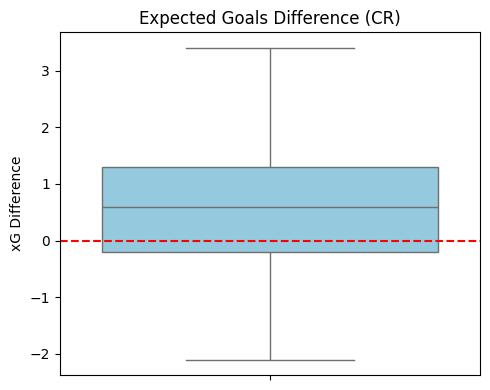

In [83]:
plt.figure(figsize=(5,4))
sns.boxplot(y=xg_stats_df['diff_xg'], color='skyblue', showfliers=False)
plt.axhline(0, color='red', linestyle='--')
plt.title("Expected Goals Difference (CR)")
plt.ylabel("xG Difference")
plt.tight_layout()
plt.show()

In [69]:
# Fit a logistic regression model to estimate the impact of expected goal difference (diff_xg)
# on the probability of winning for high-reputation teams.
# Compute the marginal effects to interpret how a unit change in diff_xg affects win probability.
import statsmodels.formula.api as smf

xg_win = smf.logit("is_win ~ diff_xg", data=xg_stats_df).fit()
print(xg_win.summary())

margeff = xg_win.get_margeff()
print(margeff.summary())

Optimization terminated successfully.
         Current function value: 0.548329
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 is_win   No. Observations:                  588
Model:                          Logit   Df Residuals:                      586
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 May 2025   Pseudo R-squ.:                  0.1883
Time:                        16:27:45   Log-Likelihood:                -322.42
converged:                       True   LL-Null:                       -397.22
Covariance Type:            nonrobust   LLR p-value:                 2.113e-34
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1315      0.105     -1.256      0.209      -0.337       0.074
diff_xg        1.1090      0.

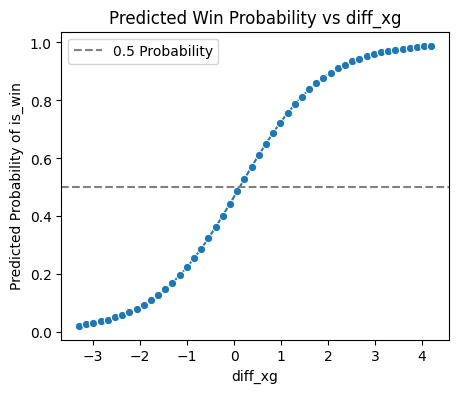

In [70]:
# Generate predicted win probabilities across the range of diff_xg values using the trained logistic model.
# This helps visualize how the expected goal difference (diff_xg) influences the probability of winning.
diff_xg_range = np.linspace(xg_stats_df['diff_xg'].min(), xg_stats_df['diff_xg'].max())

df_pred = pd.DataFrame({'diff_xg': diff_xg_range})

df_pred['pred_prob'] = xg_win.predict(df_pred)

plt.figure(figsize=(5,4))
sns.lineplot(x='diff_xg', y='pred_prob', data=df_pred, marker="o")
plt.xlabel("diff_xg")
plt.ylabel("Predicted Probability of is_win")
plt.title("Predicted Win Probability vs diff_xg")
plt.axhline(0.5, color='gray', linestyle='--', label="0.5 Probability")
plt.legend()
plt.show()

In [71]:
ref_xg = (xg_stats_df.groupby('Referee')['diff_xg'].agg(['mean', 'std', 'count']).round(2))
ref_xg = ref_xg.rename(columns={'mean': 'avg_diff_xG', 'std': 'SD_Diff_xG', 'count': 'matches'})
ref_xg = ref_xg[ref_xg['matches'] > 5]
ref_xg = ref_xg.sort_values(by='avg_diff_xG', ascending=False)

print("Per-Referee Average Diff_xG (Only Referees with > 5 Matches):")
print(ref_xg.reset_index())

Per-Referee Average Diff_xG (Only Referees with > 5 Matches):
            Referee  avg_diff_xG  SD_Diff_xG  matches
0    Niel Swarbrick         1.01        1.03        8
1      Graham Scott         0.91        1.27       15
2      Craig Pawson         0.77        1.00       54
3    Chris Kavanagh         0.73        1.20       30
4    Andre Marriner         0.71        1.12       41
5   Martin Atkinson         0.68        1.10       37
6     Jonathan Moss         0.66        1.24       38
7      Paul Tierney         0.66        0.94       45
8      Kevin Friend         0.57        1.11       29
9    Jarred Gillett         0.56        1.12       13
10   Michael Oliver         0.55        1.39       42
11      Andy Madley         0.52        1.21       13
12   Anthony Taylor         0.51        1.08       44
13     Simon Hooper         0.46        1.66       16
14   Darren England         0.37        1.21        6
15      David Coote         0.37        0.91       24
16        Lee Mason 

In [72]:
agg_df = pd.merge(grouped, ref_xg, on='Referee', how='inner')
agg_df = agg_df.loc[:, ['Referee', 'diff_win_rate', 'avg_diff_xG']]

print(agg_df.head())

          Referee  diff_win_rate  avg_diff_xG
0  Andre Marriner           0.28         0.71
1     Andy Madley           0.18         0.52
2  Anthony Taylor           0.32         0.51
3  Chris Kavanagh           0.50         0.73
4    Craig Pawson           0.30         0.77


In [75]:
cr_df = pd.merge(grouped, referee_diff_club_rep, on="Referee", how="inner")
cr_df = pd.merge(cr_df, ref_xg, on='Referee', how='inner')
cr_df = cr_df.loc[:, ['Referee', 'diff_win_rate', 'avg_diff_cards', 'avg_diff_fls', 'avg_diff_ratio', 'avg_diff_xG']]

print(cr_df.head())

          Referee  diff_win_rate  avg_diff_cards  avg_diff_fls  \
0  Andre Marriner           0.28           -0.27         -0.48   
1     Andy Madley           0.18           -0.82         -0.74   
2  Anthony Taylor           0.32           -0.25         -0.07   
3  Chris Kavanagh           0.50           -0.24          0.09   
4    Craig Pawson           0.30           -0.52         -0.94   

   avg_diff_ratio  avg_diff_xG  
0            0.07         0.71  
1            1.29         0.52  
2            0.49         0.51  
3            0.53         0.73  
4            0.56         0.77  


In [81]:
# Calculate a composite bias score for each referee based on multiple standardized metrics.
# Z-score normalization is applied to ensure comparability, and weights reflect the directional influence of each metric.
# A final bias label is assigned based on whether the composite score is above the median.
metrics = ['diff_win_rate', 'avg_diff_cards', 'avg_diff_fls', 'avg_diff_ratio', 'avg_diff_xG']

for metric in metrics:
  cr_df[metric + '_z'] = (cr_df[metric] - cr_df[metric].mean()) / cr_df[metric].std()

weights = {
    'diff_win_rate_z': 1.5,
    'avg_diff_cards_z': -3,
    'avg_diff_fls_z': -1,
    'avg_diff_ratio_z': 3,
    'avg_diff_xG_z': 2
}

total_abs_weight = sum(abs(w) for w in weights.values())
cr_df['composite_bias'] = (
    weights['diff_win_rate_z'] * cr_df['diff_win_rate_z'] +
    weights['avg_diff_cards_z'] * cr_df['avg_diff_cards_z'] +
    weights['avg_diff_fls_z'] * cr_df['avg_diff_fls_z'] +
    weights['avg_diff_ratio_z'] * cr_df['avg_diff_ratio_z'] +
    weights['avg_diff_xG_z'] * cr_df['avg_diff_xG_z']
) / total_abs_weight

cr_df['composite_bias'] = cr_df['composite_bias'].round(2)
cr_df = cr_df.sort_values(by='composite_bias', ascending=False)

threshold = cr_df['composite_bias'].median()
cr_df['bias'] = (cr_df['composite_bias'] > threshold).astype(int)

print("Composite Bias Scores by Referee:")
print(cr_df[['Referee', 'composite_bias', 'bias']].sort_values(by='composite_bias', ascending=False).reset_index(drop=True))

Composite Bias Scores by Referee:
            Referee  composite_bias  bias
0    Niel Swarbrick            1.00     1
1       Andy Madley            0.81     1
2      Simon Hooper            0.73     1
3      Craig Pawson            0.59     1
4      Graham Scott            0.48     1
5      Paul Tierney            0.48     1
6    Darren England            0.39     1
7    Chris Kavanagh            0.29     1
8    Michael Oliver            0.20     1
9    Jarred Gillett            0.11     1
10   Andre Marriner            0.05     1
11        Lee Mason           -0.03     0
12   Anthony Taylor           -0.03     0
13    Jonathan Moss           -0.04     0
14        Mike Dean           -0.06     0
15  Martin Atkinson           -0.08     0
16     Kevin Friend           -0.16     0
17     Peter Bankes           -0.23     0
18     Robert Jones           -0.38     0
19   Stuart Attwell           -0.47     0
20      John Brooks           -0.66     0
21      David Coote           -1.20     0


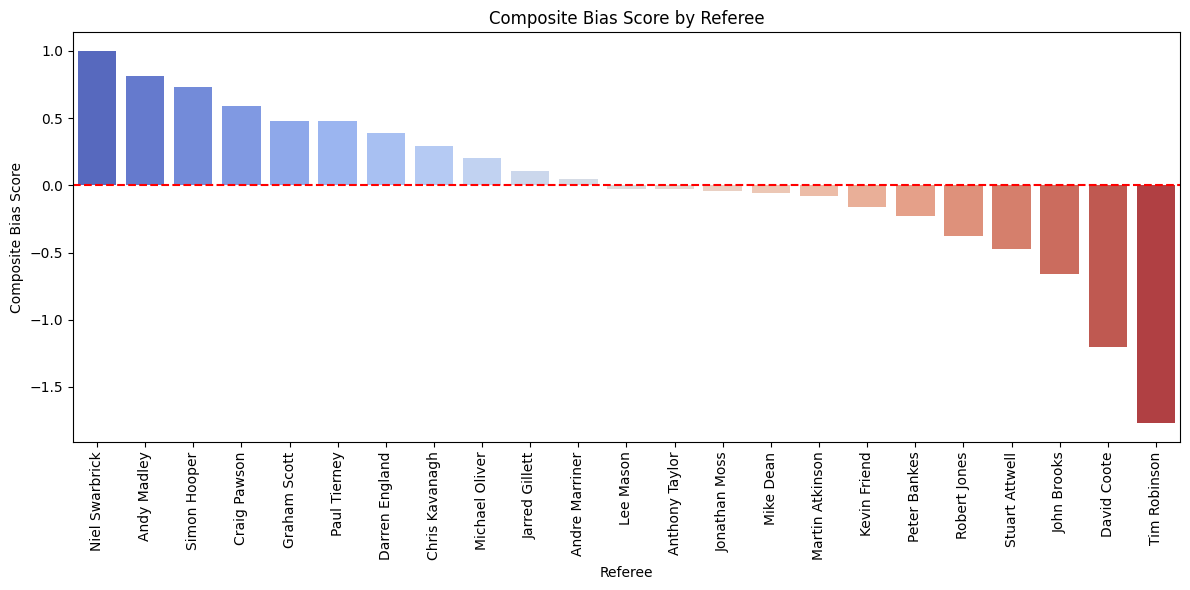

In [82]:
plt.figure(figsize=(12,6))
sns.barplot(x='Referee', y='composite_bias', data=cr_df, palette="coolwarm")
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=90)
plt.xlabel("Referee")
plt.ylabel("Composite Bias Score")
plt.title("Composite Bias Score by Referee")
plt.tight_layout()
plt.show()